#Sensitive Text Data Detection

## Importing libraries and downloading the dataset

In [4]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[]

In [5]:
# Importing the necessary libraries
import tensorflow as tf
import json
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Downloading the dataset
git_folder = "/content/Sensitive-Data-Detection"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/Gltknzk/Sensitive-Data-Detection.git

dataset_folder = git_folder + "/text_dataset/"
sensitive_datafile = "SensitiveDataset.json"
nonsensitive_datafile = "NonSensitiveDataset.json"

Cloning into 'Sensitive-Data-Detection'...
remote: Enumerating objects: 1081, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1081 (delta 0), reused 5 (delta 0), pack-reused 1076
Receiving objects: 100% (1081/1081), 236.73 MiB | 30.49 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [6]:
# Necessary Variables
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

## Preprocessing the dataset

In [7]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more 
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are",
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by",
             "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further",
             "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers",
             "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in",
             "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor",
             "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own",
             "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's",
             "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd",
             "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very",
             "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  with open(dataset_folder + filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    dataList.append([sentence, label])

# Loading both sensitive and non-sensitive dataset
loadDataset(sensitive_datafile)
loadDataset(nonsensitive_datafile)

# Shuffling the dataset randomly
random.shuffle(dataList)

# Dataset size: 31500 (approx)
print("Dataset Size: ", len(dataList))

# Dataset has both sentences and labels
for item in dataList:
  sentences.append(item[0])
  labels.append(item[1])

# Splitting up the total dataset
# Training size = 20000
# Validation size = 11500 (approx)
training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[0])
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences[0])

Dataset Size:  31576
Training Dataset Size:  20000
Sample Training Data: username:chi-ho, password:motherfucker, email:chi-ho@sky.com, phone no:3563185105
Validation Dataset Size:  11576
Sample Validation Data: Michele, young woman works dead-end job, convinced untrustworthy man named Buz go Los Angeles, claims connections can land job Go-Go dancer. The two head L.A., along hitchhiker named Critter. Once Los Angeles, Michele gets job dancer learns club owner dancers connected drug trade.


In [8]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 103196
Saving the word index as JSON


In [9]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

## Model

In [15]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    # Global average pooling operation (Flattening)
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(24, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 32)            96000     
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 128)           20608     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 119,729
Trainable params: 119,729
Non-trainable params: 0
________________________________________________

## Training

In [16]:
num_epochs = 10

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.0453 - accuracy: 0.9931 - val_loss: 0.0033 - val_accuracy: 0.9991
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 3/10
625/625 [==============================] - 7s 10ms/step - loss: 5.3018e-04 - accuracy: 0.9999 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 4/10
625/625 [==============================] - 7s 10ms/step - loss: 3.6385e-04 - accuracy: 0.9999 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 3.0878e-04 - accuracy: 0.9999 - val_loss: 6.0828e-04 - val_accuracy: 0.9997
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 2.3799e-04 - accuracy: 0.9999 - val_loss: 5.7859e-04 - val_accuracy: 0.9998
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 2.0646e-04 - accuracy: 0.9999 - val_loss: 3

## Plotting Accuracy and Loss Functions

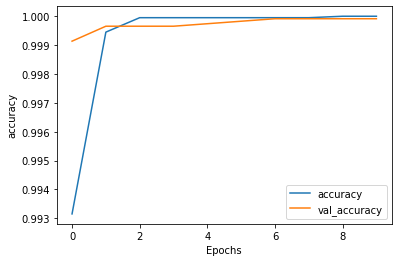

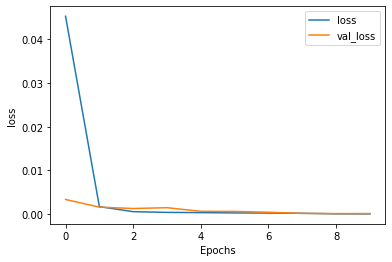

In [17]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix

Confusion Matrix
Accuracy for 2894 Test Data =  100.0
Accuracy for 5788 Test Data =  100.0
Accuracy for 8682 Test Data =  99.98848191660908
Accuracy for 11576 Test Data =  99.9913614374568


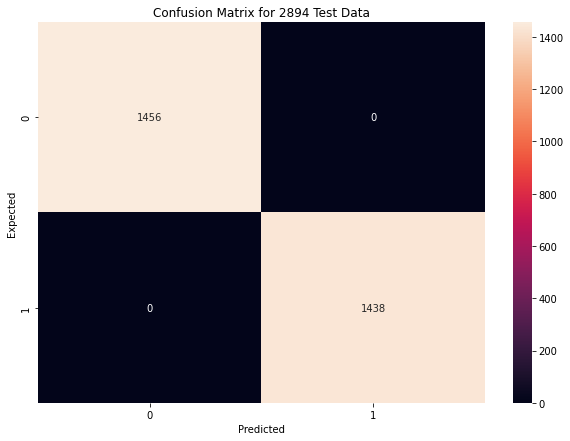

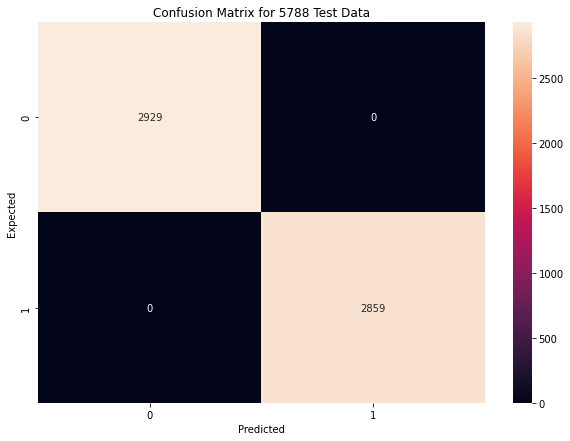

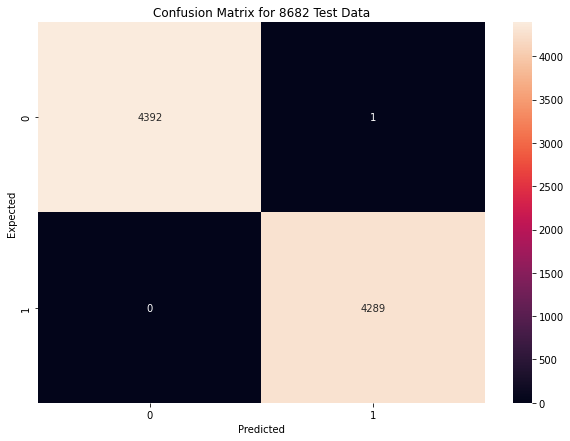

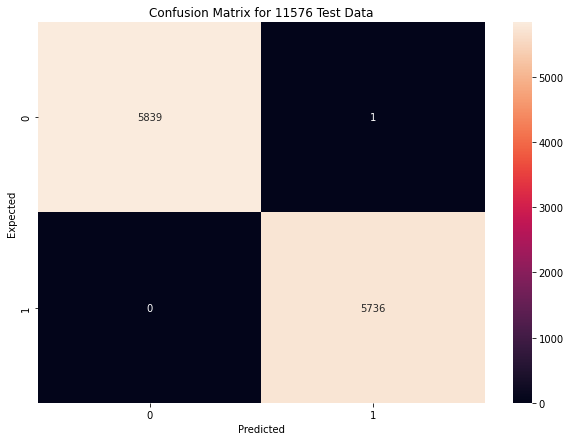

In [18]:
import seaborn
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
y_predicted_labels = y_predicted > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

## Saving the model

In [19]:
# Save and convert the model (Used for deploying in web application)
model.save('text.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/text.h5 /content/text_model
print("Model converted to JSON successfully")

Saved the model successfully
Already using interpreter /usr/bin/python3
Using base prefix '/usr'
New python executable in /content/venv/bin/python3
Not overwriting existing python script /content/venv/bin/python (you must use /content/venv/bin/python3)
Installing setuptools, pkg_resources, pip, wheel...done.
Model converted to JSON successfully


## Sample Example

In [21]:
# Sample examples
sentence = ["His Name is John",
            "Her name is Janet",
            "date of birth:17-09-1972",
            "passport number: 123456789",
            "Phone Number is 555555555",
            "Credit card number 341-547-787",
            "Username:John",
            "Password:1345",
            "DataTera:Global Data Source for AI models",
            "Let's do this",
            "Her Race is White",
            "Race:Cacuasian",
            "Eye Color: Brown",
            "That was an awsome movie",
            "Her glucose level was very high",
            "She has sent her e-mail address for the meeting",
            "Her email:janet@gmail.com",
            "e-mail:john@gmail.com",
            "fax number:12456789",
            "Please do not share your private information"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  if predictions[i][0]>0.3:
    print("This Data is More Likely Sensitive - "+ sentence[i])
  else:
    print("This Data is Less Likely Sensitive - "+ sentence[i])

0.9517522
This Data is More Likely Sensitive - His Name is John
0.9843912
This Data is More Likely Sensitive - Her name is Janet
0.99693704
This Data is More Likely Sensitive - date of birth:17-09-1972
0.9926946
This Data is More Likely Sensitive - passport number: 123456789
0.99445796
This Data is More Likely Sensitive - Phone Number is 555555555
0.99355155
This Data is More Likely Sensitive - Credit card number 341-547-787
0.88740164
This Data is More Likely Sensitive - Username:John
0.90224075
This Data is More Likely Sensitive - Password:1345
0.00012812018
This Data is Less Likely Sensitive - DataTera:Global Data Source for AI models
0.2667417
This Data is Less Likely Sensitive - Let's do this
0.02917552
This Data is Less Likely Sensitive - Her Race is White
0.41384238
This Data is More Likely Sensitive - Race:Cacuasian
0.3299929
This Data is More Likely Sensitive - Eye Color: Brown
7.698705e-05
This Data is Less Likely Sensitive - That was an awsome movie
0.00077939034
This Data i